In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

def make_mlp(i, h, o):
    return nn.Sequential(
        nn.Linear(i, h),
        nn.ReLU(),
        nn.Linear(h, o),
    )

X = torch.randn(512, 1) * 1
T = torch.randn(512, 1) * 3
XT = torch.cat([X, T, X*T], axis=1)
mlp = make_mlp(3, 1024, 1)
Y = mlp(XT).detach() + X

Text(0, 0.5, 'Outcome')

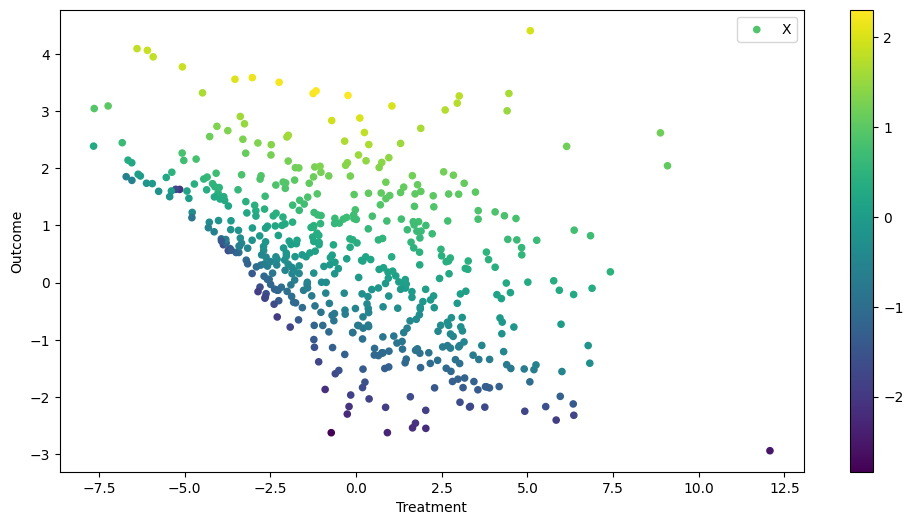

In [531]:
plt.figure(figsize=(12, 6))
plt.scatter(T, Y, c=X.numpy().flatten(), s=20)
plt.legend("X")
plt.colorbar()
plt.xlabel("Treatment")
plt.ylabel("Outcome")

Text(0, 0.5, 'Y')

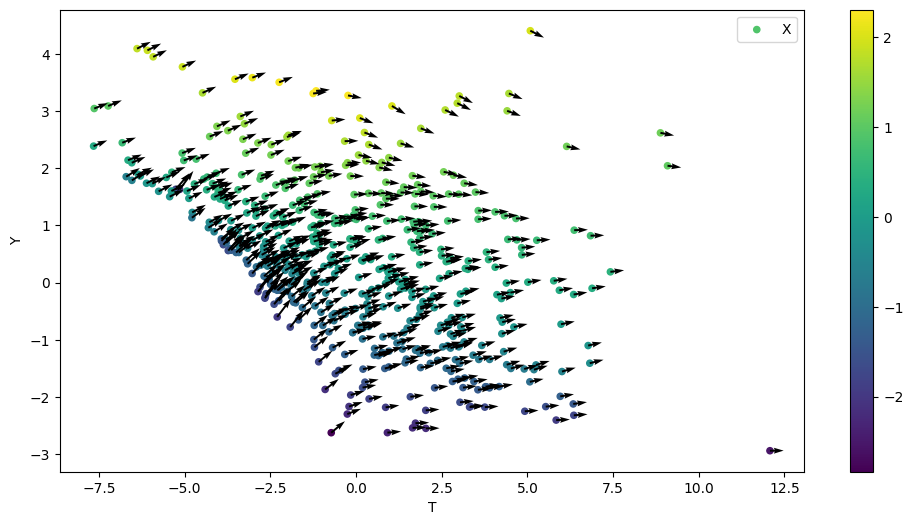

In [541]:
XTtick = torch.cat([X, T.add(1), X*T.add(1)], axis=1)
Ytick = mlp(XTtick).detach() + X

plt.figure(figsize=(12, 6))
plt.scatter(T, Y, c=X.numpy().flatten(), s=20)
plt.legend("X")
plt.colorbar()

dT = torch.ones(len(T))
dY = (Y - Ytick)
scale=0.4
plt.quiver(T, Y, dT*scale, dY*scale, angles='xy', scale_units='xy', scale=1)

plt.xlabel('T')
plt.ylabel('Y')

In [707]:
# create a context from which to learn
n_nodes = 8
n_samples = 128
edge_drop = 0.5

# determine connectivity of DAG
edges = torch.rand(n_nodes, n_nodes).ge(edge_drop).tril()
# determine functional relationships, e.g. mlps
nodes = [make_mlp(n_nodes, 1024, 1) for _ in range(n_nodes-1)]

# init buffer, and sample noise for the first node
X = torch.zeros(n_samples, n_nodes)
X[:, 0] = torch.rand(n_samples).mul(2).sub(1)

# iterate over mlps
for idx, (node_mlp, edge_mask) in enumerate(zip(nodes, edges)):
    # apply the edge mask to X before processing with MLP to limit connectivity
    # init assumes 8 full variance variables, but we have set many to 0 with the mask, thus multiply by n_nodes
    pred = node_mlp(edge_mask * X).mul(n_nodes) 
    # additive noise, non gaussian (this is crucial for identifiabilty)
    noise = torch.rand(n_samples).mul(0.2).sub(0.1)
    # add observation to the DAGs sample buffer
    X[:, idx+1] = pred.flatten() + noise

In [719]:
# design a query and desired response, we probe the jacobian by a point perturbation
intervention = torch.zeros(8)
intervention[torch.randint(0, n_nodes, (1,))] = torch.randn(1,)
# init buffer to hold the original and perturbed twin samples
Y = torch.zeros(2, n_nodes)
# start from the same noise-seed
Y[:, 0] = torch.rand(1).mul(2).sub(1)
for idx, (node_mlp, edge_mask, interv) in enumerate(zip(nodes, edges, intervention)):
    # apply intervention to second sample (should be 0 except for 1 node)
    Y[1, idx] += interv
    pred = node_mlp(edge_mask * Y).mul(n_nodes)
    # apply the same noise to both perturbed and unperturbed.
    noise = torch.rand(1).mul(0.2).sub(0.1)
    Y[:, idx+1] = pred.flatten() + noise

<Axes: >

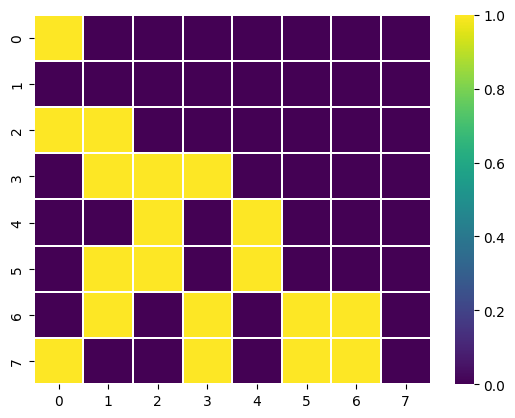

In [721]:
sns.heatmap(edges, linecolor="w", linewidths=0.01, cmap="viridis")

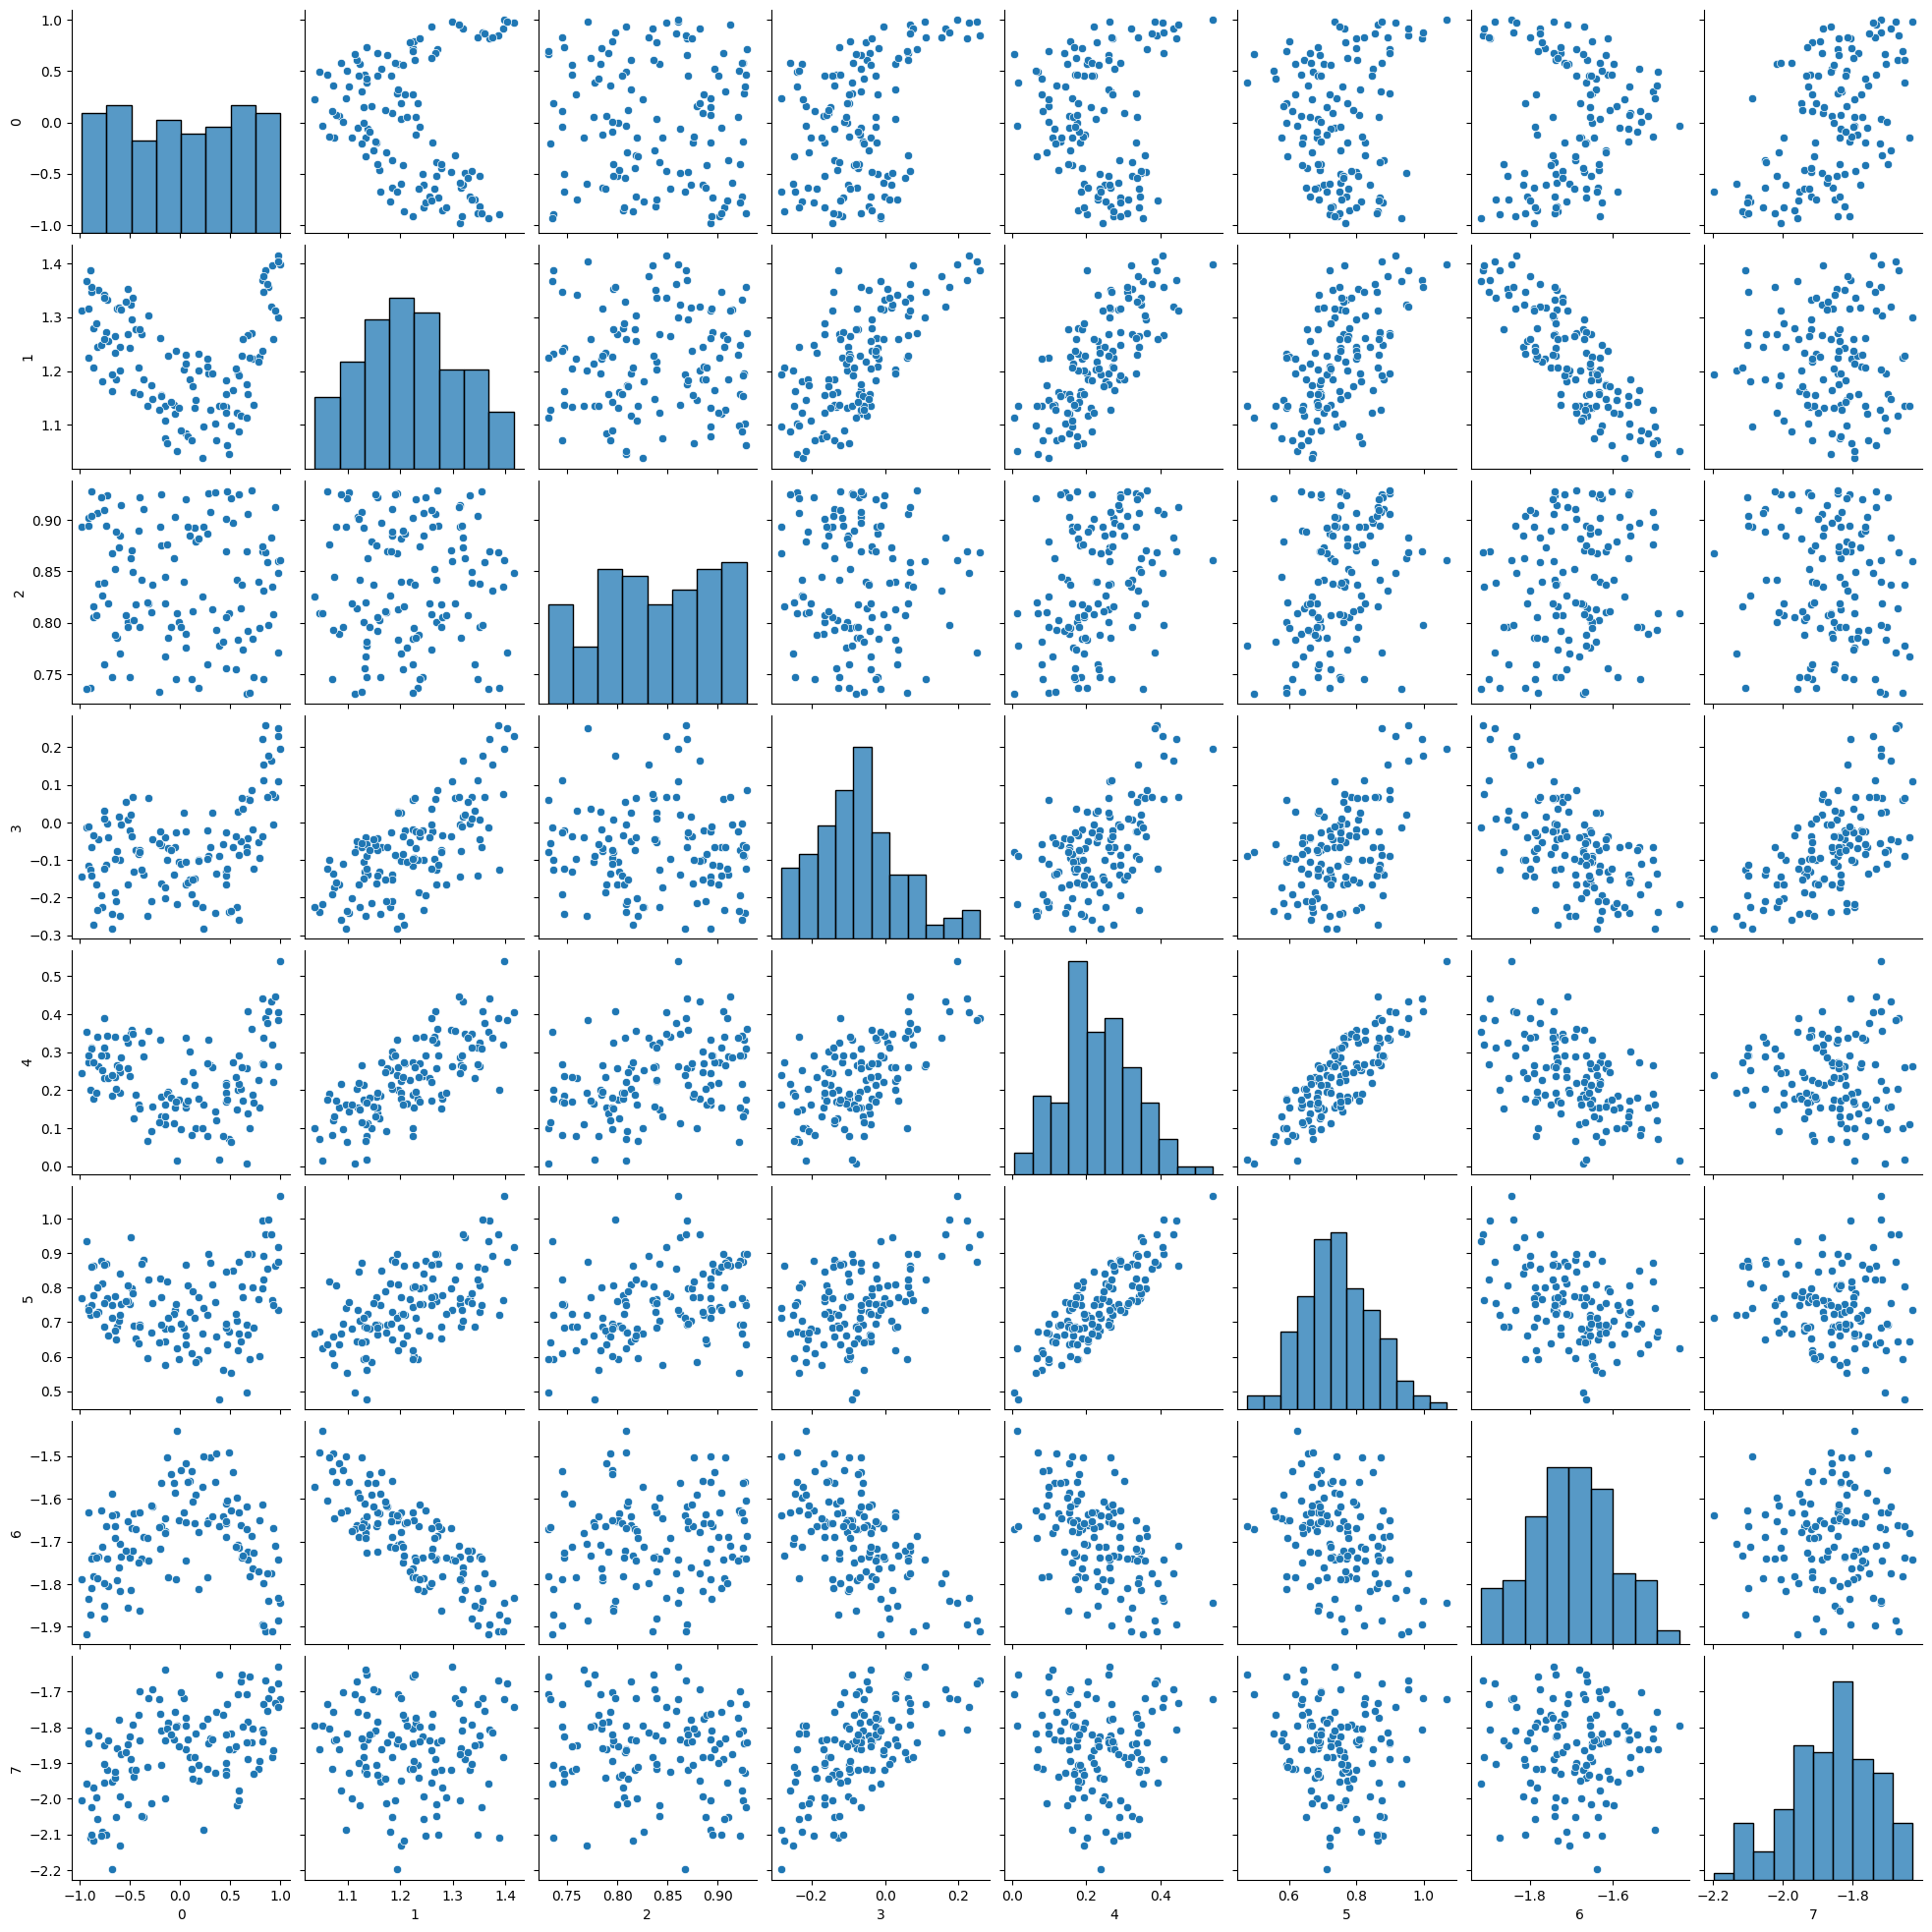

In [722]:
import seaborn as sns
import pandas as pd
sns.pairplot(pd.DataFrame(X.detach().numpy()))

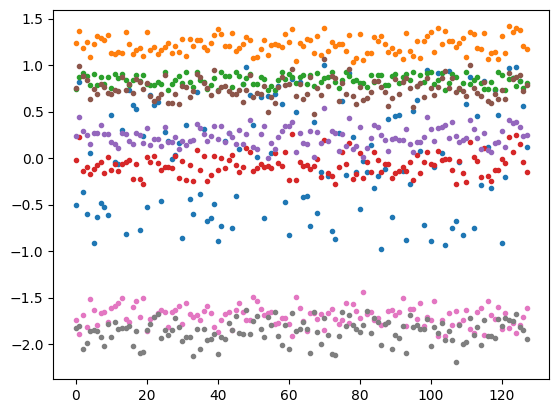

In [723]:
plt.plot(X.detach(), ".")

# now with training

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
class DAGDataset(Dataset):
    def __init__(self, num_sample=10_000):
        super().__init__()
        self.len = num_sample

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        X, I, Y = self.sample_dag()
        shuff = torch.randperm(len(I))
        X = X[:, shuff]
        I = I.unsqueeze(0)[:, shuff]
        Y = Y[:, shuff]
        unshuff = shuff.argsort()
        return X, I, Y, unshuff

    def sample_dag(self):
        n_nodes = 8
        n_samples = 512
        edge_drop = 0.5

        with torch.no_grad():
            # determine connectivity of DAG
            edges = torch.rand(n_nodes, n_nodes).ge(edge_drop).tril()
            # determine functional relationships
            nodes = [make_mlp(n_nodes, 1024, 1) for _ in range(n_nodes-1)]
            
            # init observation, and sample noise for the first node
            X = torch.zeros(n_samples, n_nodes)
            X[:, 0] = torch.rand(n_samples).mul(2).sub(1)
            
            # iterate over mlps
            for idx, (node_mlp, edge_mask) in enumerate(zip(nodes, edges)):
                # apply the edge mask to X before processing with MLP
                pred = node_mlp(edge_mask * X).mul(8)
                # we assume additive noise only
                noise = torch.rand(n_samples).mul(0.2).sub(0.1)
                # add observation of ith-node to the ancestral sample
                X[:, idx+1] = pred.flatten() + noise
    
            # for the interventional data, choose a node to intervene on
            intervention = torch.zeros(8)
            intervention[torch.randint(0, 8, (1,))] = torch.randn(1,)
            # init twin of base-line and intervened sample
            Y = torch.zeros(2, n_nodes)
            # init twins to same noise-seed
            Y[:, 0] = torch.rand(1).mul(2).sub(1)
            for idx, (node_mlp, edge_mask, interv) in enumerate(zip(nodes, edges, intervention)):
                # apply intervention to second twin only
                Y[1, idx] += interv
                pred = node_mlp(edge_mask * Y).mul(8)
                noise = torch.rand(1).mul(0.2).sub(0.1)
                Y[:, idx+1] = pred.flatten() + noise

        return X, intervention, Y

In [4]:
class InContextLerner(nn.Module):
    def __init__(self, in_dim=8, hidden=768):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden))
        self.pos_code = nn.Parameter(torch.randn(1, 1024, hidden))

        self.up = nn.Linear(in_dim, hidden)
        self.backbone = nn.Sequential(*[
            nn.TransformerEncoderLayer(
                d_model=hidden, nhead=12, dim_feedforward=hidden*4, 
                dropout=0.0, activation="gelu", batch_first=True,
                norm_first=True, bias=False)
            for _ in range(12)])
        
        self.down = nn.Sequential(
            nn.Linear(hidden, hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, in_dim),
        )

        self._initialize_weights()

    def forward(self, X):
        batch, seq, dim = X.shape
        X = self.up(X)
        X = X + self.pos_code.repeat(batch, 1, 1)[:, :seq]
        cls_tokens = self.cls_token.repeat(batch, 1, 1)
        out = self.backbone(torch.cat([X, cls_tokens], dim=1))
        pred = self.down(out[:, -1])
        return pred

    def loss(self, X, Y):
        pred = self.forward(X)
        return pred.sub(Y).square().mean()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Xavier initialization for linear layers
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Bias initialized to zero
            # Initialize Transformer Encoder layers
            elif isinstance(m, nn.TransformerEncoderLayer):
                for param in m.parameters():
                    if param.dim() > 1:  # Weights (ignore biases as they are not present)
                        nn.init.xavier_uniform_(param)
        
        nn.init.normal_(self.cls_token, mean=0, std=0.02)
        nn.init.normal_(self.pos_code, mean=0, std=0.02)

In [5]:
ds = DAGDataset()
dl = DataLoader(ds, batch_size=8)
model = InContextLerner().to('mps')
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=1e-6)
lambdas = torch.cat([
    torch.linspace(0, 1, 100),
    torch.linspace(1, 0.1, 1000*10_000),
])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda x: lambdas[x])

In [ ]:
ema = lambda mu, dx: mu*0.99 + dx*0.01 if mu else dx
loss_avg = None

for epoch in range(1000):
    for idx, (X, I, Y, unshuff) in enumerate(dl):
        observed = torch.cat([X, Y[:, [0]], I], dim=1).to('mps')
        target = Y[:, [1]].to('mps')
        loss = model.loss(observed, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        loss_avg = ema(loss_avg, loss.item())
        if idx % 1 == 0:
            print(f"{epoch=:04d} {idx=:04d} {loss.item()=:0.4f}, {loss_avg=:0.4f}")

epoch=0000 idx=0000 loss.item()=7.1041, loss_avg=7.1041
epoch=0000 idx=0001 loss.item()=7.7066, loss_avg=7.1102
epoch=0000 idx=0002 loss.item()=6.5134, loss_avg=7.1042
epoch=0000 idx=0003 loss.item()=6.0320, loss_avg=7.0935
epoch=0000 idx=0004 loss.item()=5.6386, loss_avg=7.0789
epoch=0000 idx=0005 loss.item()=3.9922, loss_avg=7.0481
epoch=0000 idx=0006 loss.item()=3.7973, loss_avg=7.0156
epoch=0000 idx=0007 loss.item()=2.6191, loss_avg=6.9716
epoch=0000 idx=0008 loss.item()=5.0450, loss_avg=6.9523
epoch=0000 idx=0009 loss.item()=2.6882, loss_avg=6.9097
epoch=0000 idx=0010 loss.item()=3.5422, loss_avg=6.8760
epoch=0000 idx=0011 loss.item()=3.5445, loss_avg=6.8427
epoch=0000 idx=0012 loss.item()=3.3001, loss_avg=6.8073
epoch=0000 idx=0013 loss.item()=3.4212, loss_avg=6.7734
epoch=0000 idx=0014 loss.item()=3.7046, loss_avg=6.7427
epoch=0000 idx=0015 loss.item()=3.7372, loss_avg=6.7127
epoch=0000 idx=0016 loss.item()=4.8569, loss_avg=6.6941
epoch=0000 idx=0017 loss.item()=3.5332, loss_avg